# Spaceship Titanic

This is a notebook rather long. It's not a try to get a good ranking in the competition. It is my second attempt to experiment and learn on feature analysis, imputation and engineering. As you can see, I have generated new features, but not all them were used finally. I've discarded several of them for the final model. They were just part of the data exploration.

I've got some ideas from other scientist's notebooks, and I thank them a lot. Their work really helped me.

1. [Data load](#data_load)
2. [Review data](#review_data)
3. [Feature engineering](#feature_engineering)
4. [Preparation of the training datasets](#preparation_datasets)
5. [Training the model](#training_model)
6. [Make the prediction](#make_prediction)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings 
warnings.simplefilter(action='ignore')
pd.options.mode.chained_assignment = None 

<a id='data_load'></a>
# 1. Data load

In [2]:
# Load train dataset
train_df = pd.read_csv('../input/spaceship-titanic/train.csv', sep=',', encoding='UTF-8')

print(f'Dimensions - Train {train_df.shape}')

train_df.head()

Dimensions - Train (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
# Load test dataset
test_df = pd.read_csv('../input/spaceship-titanic/test.csv', sep=',', encoding='UTF-8')

print(f'Dimensions - Test {test_df.shape}')

test_df.head()

Dimensions - Test (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [4]:
train_df['Transported'].describe()
train_df.groupby(['Transported'])['Transported'].count().head()

Transported
False    4315
True     4378
Name: Transported, dtype: int64

<a id='review_data'></a>
# 2. Review data

In [5]:
# For the data analysis and to simplify feature engineering, I unify both datasets.

test_df['Transported'] = 'Unknown'
combi_df = pd.concat([train_df, test_df], ignore_index=True)

print(f'Train dataset: {len(train_df)}')
print(f'Test dataset: {len(test_df)}')
print(f'Combined: {len(combi_df)}')

Train dataset: 8693
Test dataset: 4277
Combined: 12970


In [6]:
# Check missing values

combi_df.isna().sum()/len(combi_df)

PassengerId     0.000000
HomePlanet      0.022205
CryoSleep       0.023901
Cabin           0.023053
Destination     0.021126
Age             0.020817
VIP             0.022822
RoomService     0.020278
FoodCourt       0.022282
ShoppingMall    0.023593
Spa             0.021897
VRDeck          0.020663
Name            0.022668
Transported     0.000000
dtype: float64

<a id='feature_engineering'></a>
# 3. Feature engineering

In [7]:
# Make a copy for feature engineering
combi_2 = combi_df.copy()

In [8]:
# General logical values conversion:
#   True --> 1
#   False --> 0

## Feature: *PassengerId*

In [9]:
combi_2['PassengerId'].describe()

count       12970
unique      12970
top       0001_01
freq            1
Name: PassengerId, dtype: object

In [10]:
# Extract the number of members in a group and de group ID
combi_2['GroupID'] = combi_2['PassengerId'].apply(lambda x: x.split('_')[0])
combi_2['GroupNum'] = combi_2['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)

In [11]:
# Get de number of members of each group
combi_2['GroupMembers'] = combi_2.groupby(['GroupID'])['GroupNum'].transform('max')

## Feature (new): *GroupMembers*

In [12]:
combi_2.groupby(['GroupMembers'])['GroupMembers'].count().sort_values(ascending = False).head(10)

GroupMembers
1    7145
2    2590
3    1506
4     616
5     380
7     329
6     252
8     152
Name: GroupMembers, dtype: int64

<AxesSubplot:xlabel='GroupMembers', ylabel='count'>

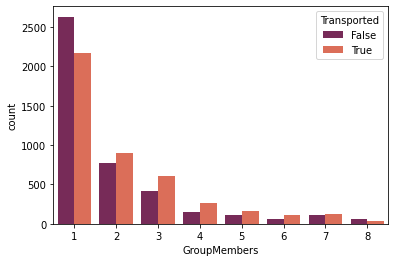

In [13]:
# Let's see the relationship between GroupMembers and Transported
sns.countplot(x='GroupMembers', hue='Transported', palette='rocket', 
              data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature: *HomePlanet*

In [14]:
combi_2['HomePlanet'].describe()

count     12682
unique        3
top       Earth
freq       6865
Name: HomePlanet, dtype: object

In [15]:
combi_2.fillna('Unknown').groupby(['HomePlanet'])['HomePlanet'].count().head()

HomePlanet
Earth      6865
Europa     3133
Mars       2684
Unknown     288
Name: HomePlanet, dtype: int64

In [16]:
# I'll impute the missing values once all features are analyzed.

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

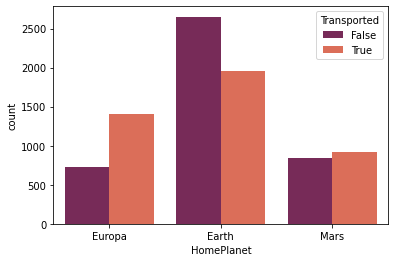

In [17]:
# Let's see the relationship between HomePlanet and Transported
sns.countplot(x='HomePlanet', hue='Transported', palette='rocket', 
              data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature: *CryoSleep*

In [18]:
combi_2['CryoSleep'].describe()

count     12660
unique        2
top       False
freq       8079
Name: CryoSleep, dtype: object

In [19]:
combi_2.fillna('Unknown').groupby(['CryoSleep'])['CryoSleep'].count().head()

CryoSleep
False      8079
True       4581
Unknown     310
Name: CryoSleep, dtype: int64

In [20]:
# Impute missing data with the most frequent value (False)
combi_2.loc[combi_2['CryoSleep'].isna(), 'CryoSleep'] = False

<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

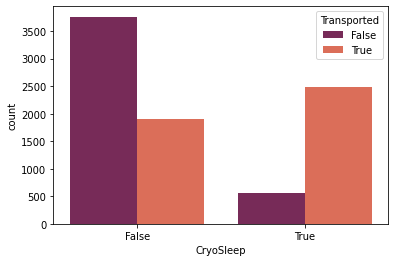

In [21]:
# Let's see the relationship between CryoSleep and Transported
sns.countplot(x='CryoSleep', hue='Transported', palette='rocket',
              data=combi_2[combi_2['Transported'] != 'Unknown'])

# In case of CryoSleep=True, it's highly probably to be transported.

In [22]:
# and convert logic values to float
combi_2['CryoSleep'] = combi_2['CryoSleep'].replace({False:0, True:1})

## Feature: *Cabin*

In [23]:
combi_2['Cabin'].describe()

count       12671
unique       9825
top       G/734/S
freq            8
Name: Cabin, dtype: object

In [24]:
combi_2.groupby(['Cabin'])['Cabin'].count().sort_values(ascending = False).head(10)

Cabin
G/734/S     8
G/160/P     8
G/1368/P    7
E/228/S     7
G/1476/S    7
D/176/S     7
F/1411/P    7
G/748/S     7
D/273/S     7
C/21/P      7
Name: Cabin, dtype: int64

In [25]:
# Impute the missing data with a ficticious value ('X/0/X')
combi_2['Cabin'].fillna('X/0/X', inplace=True)

In [26]:
# Extract the Deck and the Side from the Cabin code.
combi_2['Deck'] = combi_2['Cabin'].apply(lambda x: x.split('/')[0])
combi_2['CabinNum'] = combi_2['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
combi_2['Side'] = combi_2['Cabin'].apply(lambda x: x.split('/')[2])


# Get the number of passengers in the cabin
combi_2['CabinPassengers'] = combi_2.groupby(['Cabin'])['PassengerId'].transform('count').astype(int)

## Feature (new): *CabinNum* 

(0.0, 2000.0)

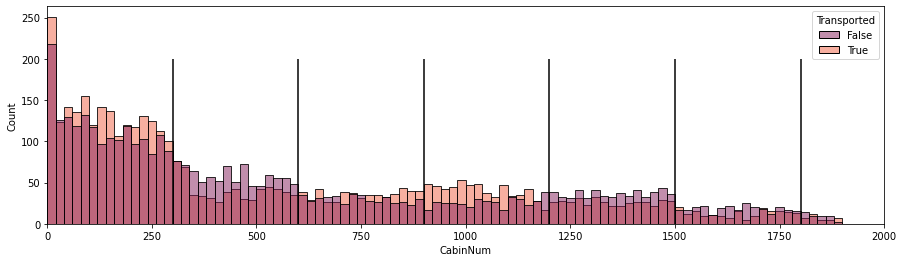

In [27]:
# As @samuelcortinhas pointed, it appears that CabinNum is grouped into segments of 300 cabins. 
# Perhaps, it is due to the location in the ship, but it's a guess.
plt.figure(figsize=(15,4))
sns.histplot(x='CabinNum', hue='Transported', binwidth=20, palette='rocket',
             data=combi_2[combi_2['Transported'] != 'Unknown'])
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.xlim([0,2000])

In [28]:
# Group the cabins into the chunks (one-hot encoding)

combi_2['CabinChunk_1'] = (combi_2['CabinNum'] < 300).astype(int)   # one-hot encoding
combi_2['CabinChunk_2'] = ((combi_2['CabinNum'] >= 300) & (combi_2['CabinNum'] < 600)).astype(int)
combi_2['CabinChunk_3'] = ((combi_2['CabinNum'] >= 600) & (combi_2['CabinNum'] < 900)).astype(int)
combi_2['CabinChunk_4'] = ((combi_2['CabinNum'] >= 900) & (combi_2['CabinNum'] < 1200)).astype(int)
combi_2['CabinChunk_5'] = ((combi_2['CabinNum'] >= 1200) & (combi_2['CabinNum'] < 1500)).astype(int)
combi_2['CabinChunk_6'] = ((combi_2['CabinNum'] >= 1500) & (combi_2['CabinNum'] < 1800)).astype(int)
combi_2['CabinChunk_7'] = (combi_2['CabinNum'] >= 1800).astype(int)

## Feature (new): *Deck*

In [29]:
combi_2['Deck'].sort_values().unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'], dtype=object)

In [30]:
combi_2.groupby(['Deck'])['Deck'].count().head(20)

Deck
A     354
B    1141
C    1102
D     720
E    1323
F    4239
G    3781
T      11
X     299
Name: Deck, dtype: int64

<AxesSubplot:xlabel='Deck', ylabel='count'>

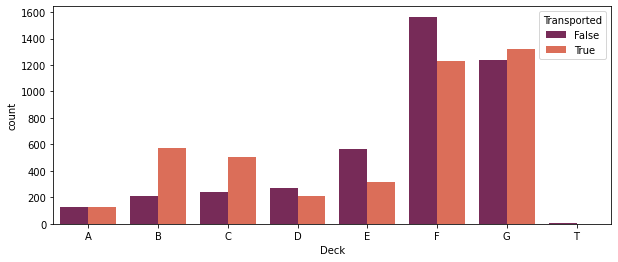

In [31]:
# Let's see the relationship between Deck and Transported
plt.figure(figsize=(10,4))
sns.countplot(x='Deck', hue='Transported', palette='rocket', order=['A','B','C','D','E','F','G','T'],
              data=combi_2[combi_2['Transported'] != 'Unknown'])

In [32]:
# I'll impute the missing values later.

## Feature (new): *Side*

In [33]:
combi_2.groupby(['Side'])['Side'].count().head()

Side
P    6290
S    6381
X     299
Name: Side, dtype: int64

<AxesSubplot:xlabel='Side', ylabel='count'>

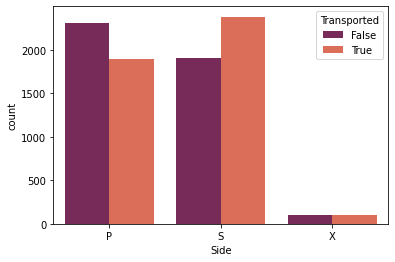

In [34]:
# Let's see the relationship between Side and Transported
sns.countplot(x='Side', hue='Transported', palette='rocket',
              data=combi_2[combi_2['Transported'] != 'Unknown'])

In [35]:
# Generate the dummy variables
combi_2['Side_copy'] = combi_2['Side'].copy()
combi_2 = pd.get_dummies(combi_2, columns=['Side'], drop_first=False)
combi_2 = combi_2.rename({'Side_copy': 'Side'}, axis=1)
combi_2.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'GroupID', 'GroupNum', 'GroupMembers', 'Deck',
       'CabinNum', 'CabinPassengers', 'CabinChunk_1', 'CabinChunk_2',
       'CabinChunk_3', 'CabinChunk_4', 'CabinChunk_5', 'CabinChunk_6',
       'CabinChunk_7', 'Side', 'Side_P', 'Side_S', 'Side_X'],
      dtype='object')

## Feature (new): *CabinPassengers*

In [36]:
combi_2.groupby(['CabinPassengers'])['CabinPassengers'].count().head(10)

CabinPassengers
1      8141
2      2066
3      1095
4       596
5       350
6       288
7       119
8        16
299     299
Name: CabinPassengers, dtype: int64

In [37]:
# In case the cabin 'X/0/X', the value should be 0
combi_2.loc[combi_2['Cabin'] == 'X/0/X', 'CabinPassengers'] = 0

<AxesSubplot:xlabel='CabinPassengers', ylabel='count'>

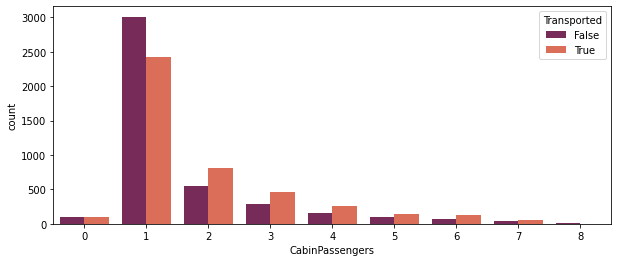

In [38]:
# Let's see the relationship between CabinPassengers and Transported
plt.figure(figsize=(10,4))

sns.countplot(x='CabinPassengers', hue='Transported', palette='rocket',
              data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature: *Destination*

In [39]:
combi_2['Destination'].describe()

count           12696
unique              3
top       TRAPPIST-1e
freq             8871
Name: Destination, dtype: object

In [40]:
combi_2.groupby(['Destination'])['Destination'].count().sort_values(ascending = False).head()

Destination
TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [41]:
# Most of the passengers are going to TRAPPIST-1e. I'll impute this value to the missing data.
combi_2['Destination'].fillna('TRAPPIST-1e', inplace=True)

<AxesSubplot:xlabel='Destination', ylabel='count'>

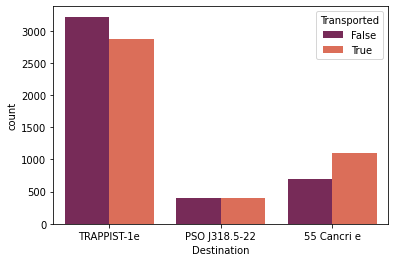

In [42]:
# Let's see the relationship between Destination and Transported
sns.countplot(x='Destination', hue='Transported', palette='rocket',
              data=combi_2[combi_2['Transported'] != 'Unknown'])

In [43]:
# and generate the dummy variables, keeping the original feature
combi_2['Destination_copy'] = combi_2['Destination'].copy()
combi_2 = pd.get_dummies(combi_2, columns=['Destination'], drop_first=False)
combi_2 = combi_2.rename({'Destination_copy': 'Destination'}, axis=1)
combi_2.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'GroupID', 'GroupNum', 'GroupMembers', 'Deck',
       'CabinNum', 'CabinPassengers', 'CabinChunk_1', 'CabinChunk_2',
       'CabinChunk_3', 'CabinChunk_4', 'CabinChunk_5', 'CabinChunk_6',
       'CabinChunk_7', 'Side', 'Side_P', 'Side_S', 'Side_X', 'Destination',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e'],
      dtype='object')

## Feature: *Age*

In [44]:
combi_2['Age'].describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [45]:
combi_2.groupby(['Age'])['Age'].count().sort_values(ascending = False).head(10)

Age
18.0    496
24.0    482
21.0    468
19.0    455
22.0    454
20.0    437
23.0    436
26.0    400
25.0    399
28.0    388
Name: Age, dtype: int64

In [46]:
# Impute missing data with a fictocious value (0). There are others fields with that value.
combi_2['Age'].fillna(0, inplace=True)

<AxesSubplot:xlabel='Age', ylabel='Density'>

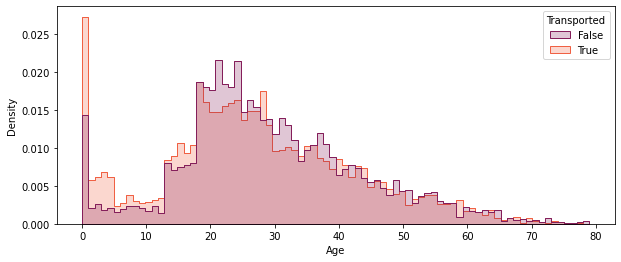

In [47]:
# Let's see the relationship between Age and Transported
n_bins = int(combi_2['Age'].max()+1)
plt.figure(figsize=(10,4))
sns.histplot(x='Age', hue='Transported', stat='density', bins=n_bins, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

# Kids are more likely to be transported

<AxesSubplot:xlabel='Age', ylabel='Count'>

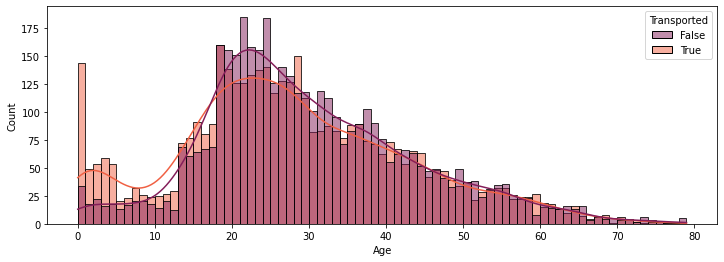

In [48]:
# Let's see the relationship between Deck and Transported
plt.figure(figsize=(12,4))
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True, palette='rocket')

# Kids are more likely to be transported

## Feature (new): *AgeGroup*

In [49]:
# I group ages in a new feature.
# I set numeric values, due to it is a ordered set.
combi_2['AgeGroup'] = 0
combi_2.loc[(combi_2['Age'] == 0), 'AgeGroup'] = 0
combi_2.loc[(combi_2['Age'] > 0) & (combi_2['Age'] < 18), 'AgeGroup'] = 1
combi_2.loc[(combi_2['Age'] >= 18) & (combi_2['Age'] < 26),'AgeGroup'] = 2
combi_2.loc[(combi_2['Age'] >= 26) & (combi_2['Age'] < 40),'AgeGroup'] = 3
combi_2.loc[(combi_2['Age'] >= 40), 'AgeGroup'] = 4

<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

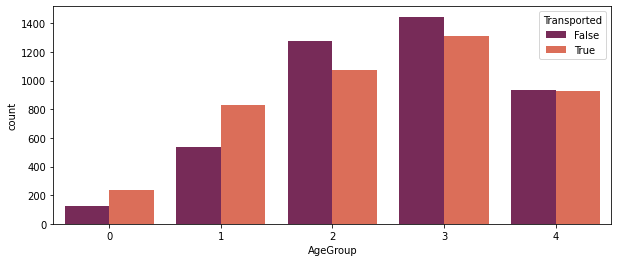

In [50]:
# Let's see the distribution
n_bins = int(combi_2['AgeGroup'].max()+1)
plt.figure(figsize=(10,4))

sns.countplot(x='AgeGroup', hue='Transported', palette='rocket',
              data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature: *VIP*

In [51]:
combi_2['VIP'].describe()

count     12674
unique        2
top       False
freq      12401
Name: VIP, dtype: object

In [52]:
combi_2.groupby(['VIP'])['VIP'].count().head()

VIP
False    12401
True       273
Name: VIP, dtype: int64

In [53]:
# Impute missing data with the most frequent value (False)
combi_2.loc[combi_2['VIP'].isna(), 'VIP'] = False

<AxesSubplot:xlabel='VIP', ylabel='count'>

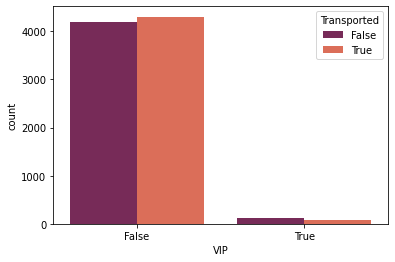

In [54]:
# Let's see the relationship between VIP and Transported
sns.countplot(x='VIP', hue='Transported', palette='rocket',
              data=combi_2[combi_2['Transported'] != 'Unknown'])

In [55]:
# and convert logic values to float
combi_2['VIP'] = combi_2['VIP'].replace({False:0, True:1})

## Feature: *RoomService*

In [56]:
combi_2['RoomService'].describe()

count    12707.000000
mean       222.897852
std        647.596664
min          0.000000
25%          0.000000
50%          0.000000
75%         49.000000
max      14327.000000
Name: RoomService, dtype: float64

In [57]:
combi_2.groupby(['RoomService'])['RoomService'].count().sort_values(ascending = False).head(10)

RoomService
0.0     8303
1.0      185
2.0      113
3.0       89
4.0       71
5.0       43
6.0       40
9.0       38
8.0       36
13.0      29
Name: RoomService, dtype: int64

In [58]:
# Impute missing data with the most frequent value.
combi_2['RoomService'].fillna(0, inplace=True)

<AxesSubplot:xlabel='RoomService', ylabel='Density'>

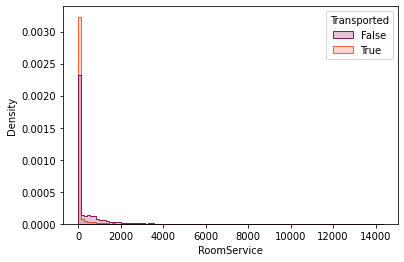

In [59]:
# Let's see the relationship between RoomService and Transported
sns.histplot(x='RoomService', hue='Transported', stat='density', bins=100, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

<AxesSubplot:xlabel='RoomService_log', ylabel='Density'>

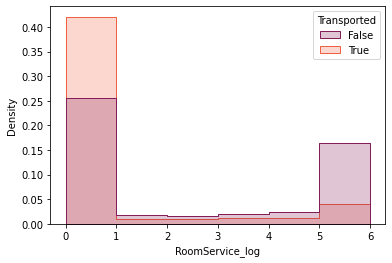

In [60]:
# In order to decrease skew in distributions, I remove outliers and apply the logarithmic transform to the feature.
clamp_max = np.percentile(combi_2['RoomService'], 80)
combi_2['RoomService_log']=np.log(1 + np.clip(combi_2['RoomService'], 0, clamp_max))

sns.histplot(x='RoomService_log', hue='Transported', stat='density', binwidth=1, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature: *FoodCourt*

In [61]:
combi_2['FoodCourt'].describe()

count    12681.000000
mean       451.961675
std       1584.370747
min          0.000000
25%          0.000000
50%          0.000000
75%         77.000000
max      29813.000000
Name: FoodCourt, dtype: float64

In [62]:
combi_2.groupby(['FoodCourt'])['FoodCourt'].count().sort_values(ascending=False).head(10)

FoodCourt
0.0     8146
1.0      175
2.0      105
4.0       75
3.0       74
5.0       52
6.0       51
7.0       40
10.0      39
9.0       36
Name: FoodCourt, dtype: int64

In [63]:
combi_2['RoomService'].isna().sum()

0

In [64]:
# Impute missing data with the most frequent value.
combi_2['FoodCourt'].fillna(0, inplace=True)

<AxesSubplot:xlabel='FoodCourt', ylabel='Density'>

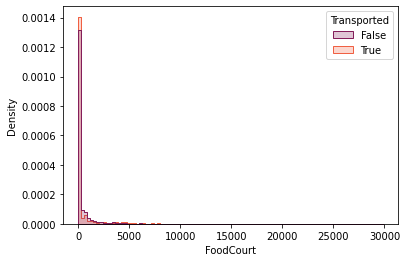

In [65]:
# Let's see the relationship between FoodCourt and Transported
sns.histplot(x='FoodCourt', hue='Transported', stat='density', bins=100, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

<AxesSubplot:xlabel='FoodCourt_log', ylabel='Density'>

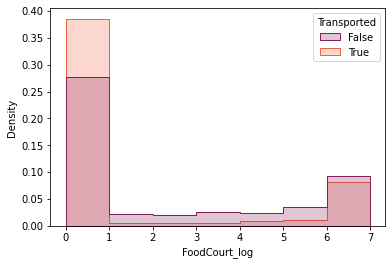

In [66]:
# In order to decrease skew in distributions, I remove outliers and apply the logarithmic transform to the feature.
clamp_max = np.percentile(combi_2['FoodCourt'], 90)
combi_2['FoodCourt_log'] = np.log(1 + np.clip(combi_2['FoodCourt'], 0, clamp_max))

sns.histplot(x='FoodCourt_log', hue='Transported', stat='density', binwidth=1, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature: *ShoppingMall*

In [67]:
combi_2['ShoppingMall'].describe()

count    12664.000000
mean       174.906033
std        590.558690
min          0.000000
25%          0.000000
50%          0.000000
75%         29.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

In [68]:
combi_2.groupby(['ShoppingMall'])['ShoppingMall'].count().sort_values(ascending = False).head(10)

ShoppingMall
0.0    8331
1.0     225
2.0     112
3.0      94
4.0      69
7.0      55
5.0      49
6.0      46
9.0      45
8.0      44
Name: ShoppingMall, dtype: int64

In [69]:
# Impute missing data with the most frequent value.
combi_2['ShoppingMall'].fillna(0, inplace=True)

<AxesSubplot:xlabel='ShoppingMall', ylabel='Density'>

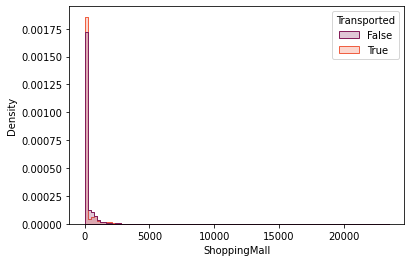

In [70]:
# Let's see the relationship between ShoppingMall and Transported
sns.histplot(x='ShoppingMall', hue='Transported', stat='density', bins=100, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

<AxesSubplot:xlabel='ShoppingMall_log', ylabel='Density'>

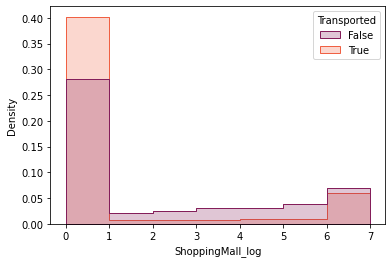

In [71]:
# In order to decrease skew in distributions, I remove outliers and apply the logarithmic transform to the feature.
clamp_max = np.percentile(combi_2['ShoppingMall'], 90)
combi_2['ShoppingMall_log']=np.log(1 + np.clip(combi_2['ShoppingMall'], 0, clamp_max))

sns.histplot(x='ShoppingMall_log', hue='Transported', stat='density', binwidth=1, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature: *Spa*

In [72]:
combi_2['Spa'].describe()

count    12686.000000
mean       308.476904
std       1130.279641
min          0.000000
25%          0.000000
50%          0.000000
75%         57.000000
max      22408.000000
Name: Spa, dtype: float64

In [73]:
combi_2.groupby(['Spa'])['Spa'].count().sort_values(ascending=False).head(10)

Spa
0.0    7935
1.0     218
2.0     148
3.0      82
4.0      73
5.0      69
6.0      56
7.0      53
8.0      50
9.0      44
Name: Spa, dtype: int64

In [74]:
# Impute missing data with the most frequent value.
combi_2['Spa'].fillna(0, inplace=True)

<AxesSubplot:xlabel='Spa', ylabel='Density'>

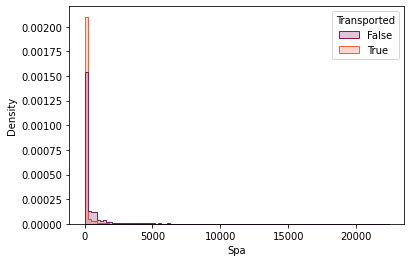

In [75]:
# Let's see the relationship between Spa and Transported
sns.histplot(x='Spa', hue='Transported', stat='density', bins=100, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

<AxesSubplot:xlabel='Spa_log', ylabel='Density'>

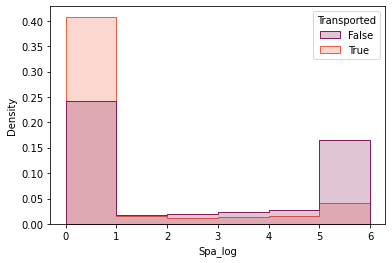

In [76]:
# In order to decrease skew in distributions, I remove outliers and apply the logarithmic transform to the feature.
clamp_max = np.percentile(combi_2['Spa'], 80)
combi_2['Spa_log']=np.log(1 + np.clip(combi_2['Spa'], 0, clamp_max))

sns.histplot(x='Spa_log', hue='Transported', stat='density', binwidth=1, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature: *VRDeck*

In [77]:
combi_2['VRDeck'].describe()

count    12702.000000
mean       306.789482
std       1180.097223
min          0.000000
25%          0.000000
50%          0.000000
75%         42.000000
max      24133.000000
Name: VRDeck, dtype: float64

In [78]:
combi_2.groupby(['VRDeck'])['VRDeck'].count().sort_values(ascending = False).head(10)

VRDeck
0.0    8252
1.0     211
2.0     108
3.0      89
5.0      68
4.0      67
6.0      53
7.0      52
8.0      40
9.0      34
Name: VRDeck, dtype: int64

In [79]:
# Impute missing data with the most frequent value.
combi_2['VRDeck'].fillna(0, inplace=True)

<AxesSubplot:xlabel='VRDeck', ylabel='Density'>

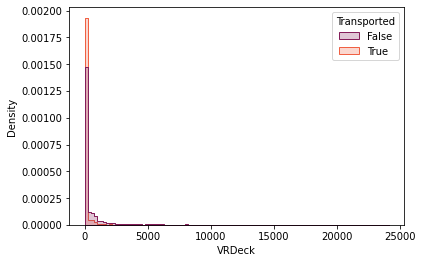

In [80]:
# Let's see the relationship between VRDeck and Transported
sns.histplot(x='VRDeck', hue='Transported', stat='density', bins=100, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

<AxesSubplot:xlabel='VRDeck_log', ylabel='Density'>

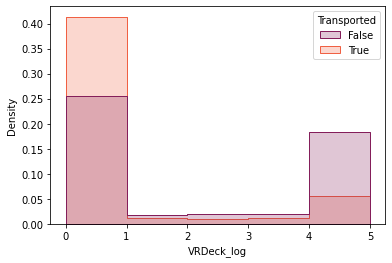

In [81]:
# In order to decrease skew in distributions, I remove outliers and apply the logarithmic transform to the feature.
clamp_max = np.percentile(combi_2['VRDeck'], 80)
combi_2['VRDeck_log'] = np.log(1 + np.clip(combi_2['VRDeck'], 0, clamp_max))

sns.histplot(x='VRDeck_log', hue='Transported', stat='density', binwidth=1, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature (new): *Amenities*

In [82]:
# Total amount of the amenities
combi_2['Amenities'] = combi_2['RoomService'] + combi_2['FoodCourt'] + combi_2['ShoppingMall'] + combi_2['Spa'] + combi_2['VRDeck']

In [83]:
combi_2.groupby(['Amenities'])['Amenities'].count().sort_values(ascending = False).head(10)

Amenities
0.0      5457
809.0      76
788.0      56
803.0      51
804.0      50
908.0      49
907.0      45
716.0      43
791.0      42
888.0      39
Name: Amenities, dtype: int64

<AxesSubplot:xlabel='Amenities', ylabel='Density'>

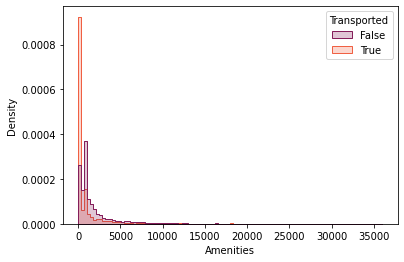

In [84]:
# Let's see the relationship between the new feature and Transported
sns.histplot(x='Amenities', hue='Transported', stat='density', bins=100, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

<AxesSubplot:xlabel='Amenities_log', ylabel='Density'>

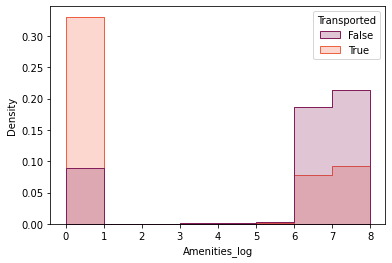

In [85]:
# In order to decrease skew in distributions, I remove outliers and apply the logarithmic transform to the feature.
clamp_max = np.percentile(combi_2['Amenities'], 80)
combi_2['Amenities_log'] = np.log(1 + np.clip(combi_2['Amenities'], 0, clamp_max))

sns.histplot(x='Amenities_log', hue='Transported', stat='density', binwidth=1, element='step', palette='rocket', 
             data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature (new): *Amenities_bin*

In [86]:
# New feature to store whether the passenger has spent money.
combi_2.loc[combi_2['Amenities'] == 0, 'Amenities_bin'] = 0
combi_2.loc[combi_2['Amenities'] > 0, 'Amenities_bin'] = 1

In [87]:
combi_2.groupby(['Amenities_bin'])['Amenities_bin'].count().sort_values(ascending = False).head()

Amenities_bin
1.0    7513
0.0    5457
Name: Amenities_bin, dtype: int64

In [88]:
# Replace individual amenities by the new one, and generate new binary features
combi_2.loc[combi_2['RoomService'] == 0, 'RoomService_bin'] = 0
combi_2.loc[combi_2['RoomService'] > 0, 'RoomService_bin'] = 1

combi_2.loc[combi_2['FoodCourt'] == 0, 'FoodCourt_bin'] = 0
combi_2.loc[combi_2['FoodCourt'] > 0, 'FoodCourt_bin'] = 1

combi_2.loc[combi_2['ShoppingMall'] == 0, 'ShoppingMall_bin'] = 0
combi_2.loc[combi_2['ShoppingMall'] > 0, 'ShoppingMall_bin'] = 1

combi_2.loc[combi_2['Spa'] == 0, 'Spa_bin'] = 0
combi_2.loc[combi_2['Spa'] > 0, 'Spa_bin'] = 1

combi_2.loc[combi_2['VRDeck'] == 0, 'VRDeck_bin'] = 0
combi_2.loc[combi_2['VRDeck'] > 0, 'VRDeck_bin'] = 1

## Feature: *Name*

In [89]:
combi_2['Name'].describe()

count                12676
unique               12629
top       Carry Contrevins
freq                     2
Name: Name, dtype: object

In [90]:
combi_2.groupby(['Name'])['Name'].count().sort_values(ascending = False).head(10)

Name
Evendy Buchansen    2
Cocors Cola         2
Lyney Sellahaney    2
Alasmon Meteet      2
Roydo Mayson        2
Gollux Reedall      2
Pennie Mcgoway      2
Keitha Josey        2
Asch Stradick       2
Loree Wolfernan     2
Name: Name, dtype: int64

In [91]:
combi_2['Name'].fillna(' Unknown', inplace=True)
combi_2['LastName'] = combi_2['Name'].apply(lambda x:x.split(" ")[1])

In [92]:
combi_2.groupby(['LastName'])['LastName'].count().sort_values(ascending = False).head(10)

LastName
Unknown        294
Buckentry       19
Belley          19
Casonston       18
Fowlesterez     18
Hinglendez      18
Gibbsonton      17
Mclardson       17
Domington       17
Haydenzier      16
Name: LastName, dtype: int64

## Feature (new): *FamilyMembers*

In [93]:
# Get the number of members of every family (peoplpe with the same last name and in the same group)
combi_2['FamilyMembers'] = combi_2.groupby(['LastName', 'GroupID'])['PassengerId'].transform('count')

In [94]:
combi_2.groupby(['FamilyMembers'])['FamilyMembers'].count().head(10)

FamilyMembers
1    7793
2    2684
3    1350
4     556
5     270
6     180
7     105
8      32
Name: FamilyMembers, dtype: int64

In [95]:
# In case the LastName is 'Unknown', the value should be 0 (no relatives)
combi_2.loc[combi_2['LastName'] == 'Unknown', 'FamilyMembers'] = 0

<AxesSubplot:xlabel='FamilyMembers', ylabel='count'>

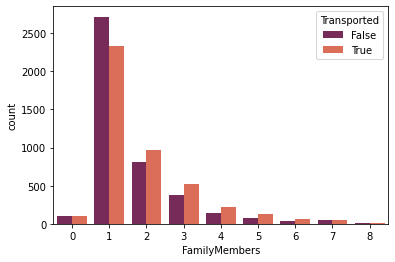

In [96]:
# Let's see the relationship between FamilyMembers and Transported
sns.countplot(x='FamilyMembers', hue='Transported', palette='rocket',
              data=combi_2[combi_2['Transported'] != 'Unknown'])

## Feature (new): *FamilyID*

In [97]:
# I generate a family ID. I't es very close to the Group ID, but conceptually are different.
combi_2['FamilyID'] = combi_2['LastName'] + '-' + combi_2['GroupID'] 

In [98]:
combi_2[['FamilyID', 'GroupID', 'FamilyMembers', 'GroupMembers']] \
    [(combi_2['GroupID'] == '9238')] \
    .sort_values('GroupID', ascending=False)

,FamilyID,GroupID,FamilyMembers,GroupMembers
12947,Garnettiz-9238,9238,2,7
12948,Emenez-9238,9238,5,7
12949,Emenez-9238,9238,5,7
12950,Emenez-9238,9238,5,7
12951,Emenez-9238,9238,5,7
12952,Garnettiz-9238,9238,2,7
12953,Emenez-9238,9238,5,7


## Feature (new): *FamilyExpense*

In [99]:
# I see than the family expense is made by only one of the members (in general).
combi_2[['FamilyID', 'GroupID', 'FamilyMembers', 'GroupMembers', 'Amenities']] \
    [(combi_2['GroupID'] == '9238')] \
    .sort_values('GroupID', ascending=False)

,FamilyID,GroupID,FamilyMembers,GroupMembers,Amenities
12947,Garnettiz-9238,9238,2,7,0.0
12948,Emenez-9238,9238,5,7,0.0
12949,Emenez-9238,9238,5,7,0.0
12950,Emenez-9238,9238,5,7,884.0
12951,Emenez-9238,9238,5,7,0.0
12952,Garnettiz-9238,9238,2,7,0.0
12953,Emenez-9238,9238,5,7,2757.0


In [100]:
combi_2['FamilyExpense'] = combi_2.groupby(['FamilyID'])['Amenities'].transform('sum')

## Feature (new): *IndividualExpense*

In [101]:
# It's more accurate the individual expense than the Amenities and the total family expense.
combi_2['IndividualExpense'] = combi_2['FamilyExpense'] / combi_2['FamilyMembers']

In [102]:
combi_2[['FamilyID', 'GroupID', 'FamilyMembers', 'GroupMembers', 'Amenities', 'FamilyExpense', 'IndividualExpense']] \
    [(combi_2['GroupID'] == '9238')] \
    .sort_values('GroupID', ascending=False)

,FamilyID,GroupID,FamilyMembers,GroupMembers,Amenities,FamilyExpense,IndividualExpense
12947,Garnettiz-9238,9238,2,7,0.0,0.0,0.0
12948,Emenez-9238,9238,5,7,0.0,3641.0,728.2
12949,Emenez-9238,9238,5,7,0.0,3641.0,728.2
12950,Emenez-9238,9238,5,7,884.0,3641.0,728.2
12951,Emenez-9238,9238,5,7,0.0,3641.0,728.2
12952,Garnettiz-9238,9238,2,7,0.0,0.0,0.0
12953,Emenez-9238,9238,5,7,2757.0,3641.0,728.2


In [103]:
# If the family expense is 0, the individual amount will be null or infinite. I set these values to 0.
combi_2.loc[combi_2['IndividualExpense'].isin([np.inf, -np.inf, np.nan]), 'IndividualExpense'] = 0

## Feature: *Transported*

In [104]:
combi_2['Transported'].unique()

array([False, True, 'Unknown'], dtype=object)

In [105]:
# Convert logic values to integers
combi_2['Transported'] = combi_2['Transported'].replace({False:0, True:1, 'Unknown':2})

<a id='impute_missing'></a>
# 3.1 Impute missing values

## Impute: *HomePlanet*

In [106]:
# Joint distribution of Group and HomePlanet
GHP_gb = combi_2.groupby(['GroupID','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
GroupID,,,
0001,0.0,1.0,0.0
0002,1.0,0.0,0.0
0003,0.0,2.0,0.0
0004,1.0,0.0,0.0
0005,1.0,0.0,0.0


In [107]:
# Missing values imputation
# (Extracted from SAMUEL CORTINHAS notebook)
HP_bef = combi_2['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index = combi_2[combi_2['HomePlanet'].isna()][(combi_2[combi_2['HomePlanet'].isna()]['GroupID']).isin(GHP_gb.index)].index

# Fill corresponding missing values
combi_2.loc[GHP_index,'HomePlanet'] = combi_2.iloc[GHP_index,:]['GroupID'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:', HP_bef)
print('#HomePlanet missing values after:', combi_2['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


<AxesSubplot:xlabel='Deck', ylabel='HomePlanet'>

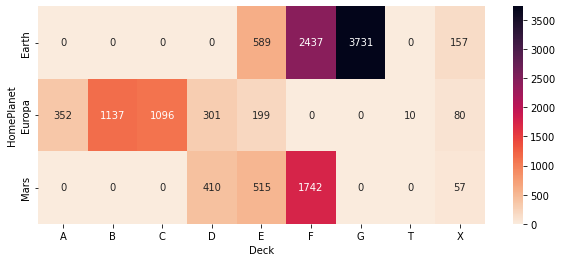

In [108]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb = combi_2.groupby(['Deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='rocket_r')

In [109]:
# Missing values before
HP_bef = combi_2['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
combi_2.loc[(combi_2['HomePlanet'].isna()) & (combi_2['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

# Deck G came from Earth
combi_2.loc[(combi_2['HomePlanet'].isna()) & (combi_2['Deck']=='G'), 'HomePlanet'] = 'Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:', combi_2['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


In [110]:
# Joint distribution of LastName and HomePlanet
SHP_gb = combi_2.groupby(['LastName','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

In [111]:
# Missing values before
HP_bef = combi_2['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index = combi_2[combi_2['HomePlanet'].isna()][(combi_2[combi_2['HomePlanet'].isna()]['LastName']).isin(SHP_gb.index)].index

# Fill corresponding missing values
combi_2.loc[SHP_index,'HomePlanet'] = combi_2.iloc[SHP_index,:]['LastName'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:', combi_2['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 5


<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

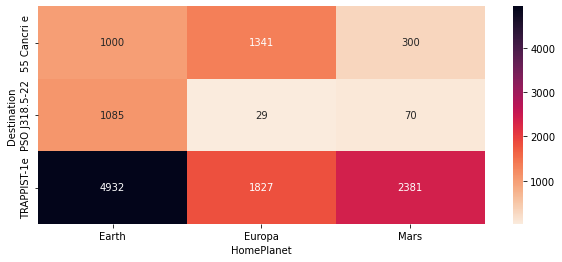

In [112]:
# Only a few HomePlanet missing values left - let's look at them
combi_2[combi_2['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

# Joint distribution of HomePlanet and Destination
HPD_gb = combi_2.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='rocket_r')

In [113]:
# Missing values before
HP_bef = combi_2['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
combi_2.loc[(combi_2['HomePlanet'].isna()) & ~(combi_2['Deck']=='D'), 'HomePlanet']='Earth'
combi_2.loc[(combi_2['HomePlanet'].isna()) & (combi_2['Deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:', HP_bef)
print('#HomePlanet missing values after:', combi_2['HomePlanet'].isna().sum())

#HomePlanet missing values before: 5
#HomePlanet missing values after: 0


In [114]:
# Generate the dummy variables, keeping the original feature
combi_2['HomePlanet_copy'] = combi_2['HomePlanet'].copy()
combi_2 = pd.get_dummies(combi_2, columns=['HomePlanet'], drop_first=False)
combi_2 = combi_2.rename({'HomePlanet_copy': 'HomePlanet'}, axis=1)
combi_2.columns

Index(['PassengerId', 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported',
       'GroupID', 'GroupNum', 'GroupMembers', 'Deck', 'CabinNum',
       'CabinPassengers', 'CabinChunk_1', 'CabinChunk_2', 'CabinChunk_3',
       'CabinChunk_4', 'CabinChunk_5', 'CabinChunk_6', 'CabinChunk_7', 'Side',
       'Side_P', 'Side_S', 'Side_X', 'Destination', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'AgeGroup',
       'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log',
       'VRDeck_log', 'Amenities', 'Amenities_log', 'Amenities_bin',
       'RoomService_bin', 'FoodCourt_bin', 'ShoppingMall_bin', 'Spa_bin',
       'VRDeck_bin', 'LastName', 'FamilyMembers', 'FamilyID', 'FamilyExpense',
       'IndividualExpense', 'HomePlanet', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars'],
      dtype='object')

## Impute: *Deck*

In [115]:
# Missing values imputation (deck=X)
# (Extracted from SAMUEL CORTINHAS notebook)
# As Samuel pointed, groups tend to be on the same cabin deck.

In [116]:
# Missing values before
GCD_gb=combi_2[combi_2['GroupMembers']>1].groupby(['GroupID','Deck'])['Deck'].size().unstack().fillna(0)
CD_bef=combi_2['Deck'][combi_2['Deck'] == 'X'].count()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=combi_2['Deck'][combi_2['Deck'] == 'X'][(combi_2[combi_2['Deck'] == 'X']['GroupID']).isin(GCD_gb.index)].index

# Fill corresponding missing values
combi_2.loc[GCD_index,'Deck']=combi_2.iloc[GCD_index,:]['GroupID'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Deck missing values before:', CD_bef)
print('#Deck missing values after:', combi_2['Deck'][combi_2['Deck'] == 'X'].count())

#Deck missing values before: 299
#Deck missing values after: 162


In [117]:
# Joint distribution
combi_2.groupby(['HomePlanet','Deck'])['Deck'].size().unstack().fillna(0)

Deck,A,B,C,D,E,F,G,T,X
HomePlanet,,,,,,,,,
Earth,0.0,0.0,0.0,1.0,601.0,2496.0,3821.0,0.0,101.0
Europa,361.0,1161.0,1122.0,309.0,204.0,0.0,0.0,11.0,29.0
Mars,0.0,0.0,0.0,420.0,529.0,1772.0,0.0,0.0,32.0


In [118]:
Deck_count = combi_2['Deck'][combi_2['Deck'] == 'X'].count()

#Passengers from Mars are most likely in deck F.
combi_2.loc[(combi_2['Deck'] == 'X') & (combi_2['HomePlanet'] == 'Mars'), 'Deck'] = 'F'

#Passengers from Europa are (more or less) most likely in deck B.
combi_2.loc[(combi_2['Deck'] == 'X') & (combi_2['HomePlanet'] == 'Europa'), 'Deck'] = 'B'

#Passengers from Earth are (more or less) most likely in deck G.
combi_2.loc[(combi_2['Deck'] == 'X') & (combi_2['HomePlanet'] == 'Earth'), 'Deck'] = 'G'

# Print number of missing values left
print('#Deck missing values before:', Deck_count)
print('#Deck missing values after:', combi_2['Deck'][combi_2['Deck'] == 'X'].count())

#Deck missing values before: 162
#Deck missing values after: 0


In [119]:
# Last check
combi_2.groupby(['Deck'])['Deck'].count().head(20)

Deck
A     361
B    1190
C    1122
D     730
E    1334
F    4300
G    3922
T      11
Name: Deck, dtype: int64

In [120]:
# Generate the dummy variables
combi_2['Deck_copy'] = combi_2['Deck'].copy()
combi_2 = pd.get_dummies(combi_2, columns=['Deck'], drop_first=False)
combi_2 = combi_2.rename({'Deck_copy': 'Deck'}, axis=1)
combi_2.columns

Index(['PassengerId', 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported',
       'GroupID', 'GroupNum', 'GroupMembers', 'CabinNum', 'CabinPassengers',
       'CabinChunk_1', 'CabinChunk_2', 'CabinChunk_3', 'CabinChunk_4',
       'CabinChunk_5', 'CabinChunk_6', 'CabinChunk_7', 'Side', 'Side_P',
       'Side_S', 'Side_X', 'Destination', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'AgeGroup',
       'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log',
       'VRDeck_log', 'Amenities', 'Amenities_log', 'Amenities_bin',
       'RoomService_bin', 'FoodCourt_bin', 'ShoppingMall_bin', 'Spa_bin',
       'VRDeck_bin', 'LastName', 'FamilyMembers', 'FamilyID', 'FamilyExpense',
       'IndividualExpense', 'HomePlanet', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Deck', 'Deck_A', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G

<a id='feature_selection'></a>
# 3.2 Feature selection

In [121]:
# Last checks. There is no object type
combi_2.select_dtypes('O').columns

Index(['PassengerId', 'Cabin', 'Name', 'GroupID', 'Side', 'Destination',
       'LastName', 'FamilyID', 'HomePlanet', 'Deck'],
      dtype='object')

In [122]:
# Check missing values
nan_cols = [i for i in combi_2.columns if combi_2[i].isnull().sum() > 0]
combi_2[nan_cols].isna().sum()/len(combi_2)

Series([], dtype: float64)

In [123]:
# Let's select the features to be included in the model
combi_2.columns

Index(['PassengerId', 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported',
       'GroupID', 'GroupNum', 'GroupMembers', 'CabinNum', 'CabinPassengers',
       'CabinChunk_1', 'CabinChunk_2', 'CabinChunk_3', 'CabinChunk_4',
       'CabinChunk_5', 'CabinChunk_6', 'CabinChunk_7', 'Side', 'Side_P',
       'Side_S', 'Side_X', 'Destination', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'AgeGroup',
       'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log',
       'VRDeck_log', 'Amenities', 'Amenities_log', 'Amenities_bin',
       'RoomService_bin', 'FoodCourt_bin', 'ShoppingMall_bin', 'Spa_bin',
       'VRDeck_bin', 'LastName', 'FamilyMembers', 'FamilyID', 'FamilyExpense',
       'IndividualExpense', 'HomePlanet', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Deck', 'Deck_A', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G

In [124]:
# Select most relevant features
train_selection = combi_2[combi_2['Transported'] != 2]

# remove features that won't use for prediction
drop_list = ['Name', 'LastName', 'PassengerId', 'GroupNum', 'GroupID', 'Cabin', 'Deck', 'Side', 'Destination', 'HomePlanet', 'FamilyID', 'CabinNum']
train_selection = train_selection.drop(columns=drop_list)

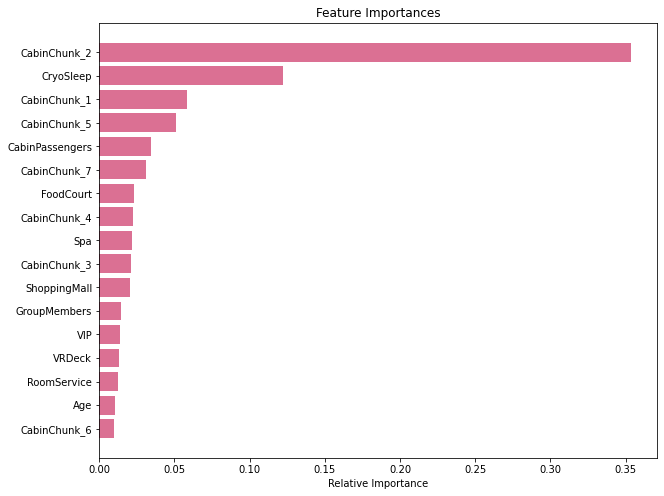

['CabinChunk_6', 'Age', 'RoomService', 'VRDeck', 'VIP', 'GroupMembers', 'ShoppingMall', 'CabinChunk_3', 'Spa', 'CabinChunk_4', 'FoodCourt', 'CabinChunk_7', 'CabinPassengers', 'CabinChunk_5', 'CabinChunk_1', 'CryoSleep', 'CabinChunk_2']


In [125]:
from xgboost import XGBClassifier

threshold = 0.01  # 0.01=1%

X_train_sel = train_selection.loc[:, train_selection.columns != 'Transported']
y_train_sel = train_selection['Transported']

#model_feat = RandomForestRegressor(random_state=101, max_depth=10)
model_feat = XGBClassifier(n_estimators=300,
                           max_depth=3,
                           objective='binary:hinge',
                           subsample=0.6,
                           colsample_bytree=0.5,
                           eta=0.1,
                           eval_metric='error',
                           use_label_encoder=False,
                           n_jobs=-1,
                           random_state=101)
model_feat.fit(X_train_sel, y_train_sel)

features = X_train_sel.columns
importances_feat = model_feat.feature_importances_
importances = importances_feat[importances_feat > threshold]
indices = np.argsort(importances)
range_idx = range(len(indices))
height = len(indices) // 2

plt.figure(figsize=(10,height))
plt.title('Feature Importances')
plt.barh(range_idx, importances[indices], align='center', fc='palevioletred')
plt.yticks(range_idx, [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

feature_list = [features[i] for i in indices]
print(feature_list)

<AxesSubplot:>

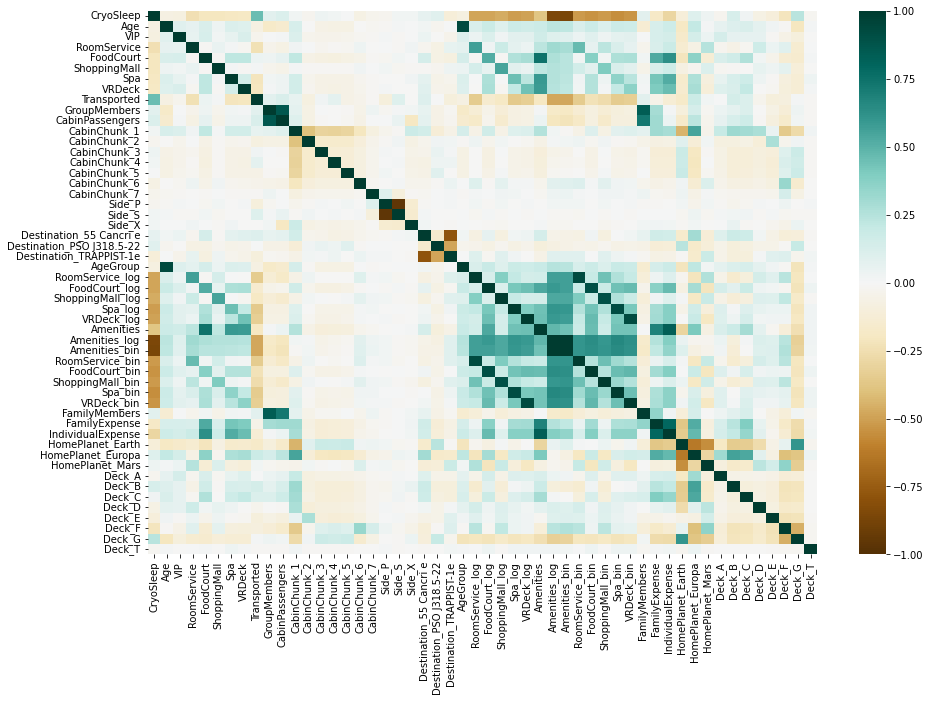

In [126]:
# correlation between all features (original + generated)
plt.figure(figsize=(15, 10))
sns.heatmap(train_selection.corr(), vmin=-1, vmax=1, cmap='BrBG')

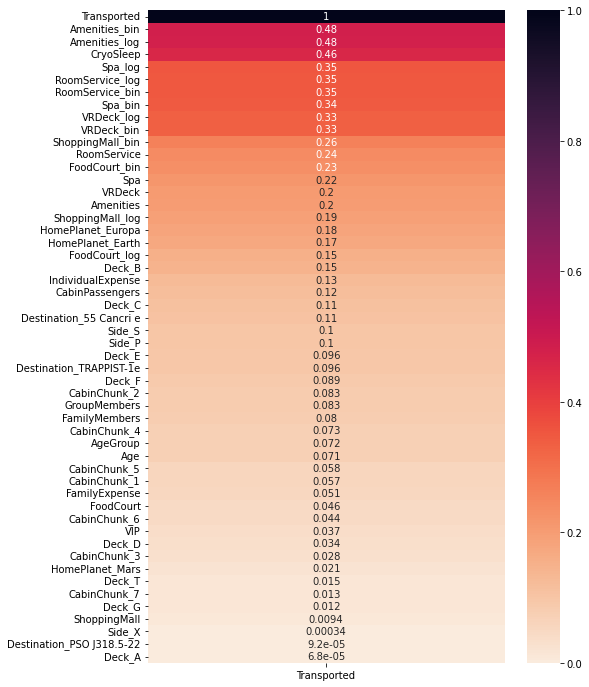

In [127]:
# Let's check the correlation of 'Transported' with the rest of features
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train_selection.corr().abs()[['Transported']].sort_values(by='Transported', ascending=False), 
                      vmin=0, vmax=1, annot=True, cmap='rocket_r')

# As we can see, there are not good features. The variables with higher correlation are closely related to CryoSleep 
# (as we can see in the heatmap), so they do not give much information either. 

In [128]:
# We take the most relevant features, in base to the previous analysis
cols_sel = ['Transported']

cols_sel = cols_sel + ['CryoSleep', 'VIP']
cols_sel = cols_sel + ['Age', 'AgeKid']
cols_sel = cols_sel + ['GroupMembers', 'CabinPassengers']    # ['FamilyMembers']

cols_sel = cols_sel + ['Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']
cols_sel = cols_sel + ['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']

cols_sel = cols_sel + ['Side_P', 'Side_S', 'Side_X']
cols_sel = cols_sel + ['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T']
cols_sel = cols_sel + ['CabinChunk_1', 'CabinChunk_2', 'CabinChunk_3', 'CabinChunk_4', 'CabinChunk_5', 'CabinChunk_6', 'CabinChunk_7']

#cols_sel = cols_sel + ['RoomService_bin', 'FoodCourt_bin', 'ShoppingMall_bin', 'Spa_bin', 'VRDeck_bin']
#cols_sel = cols_sel + ['RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log', 'VRDeck_log'] 
cols_sel = cols_sel + ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cols_sel = cols_sel + ['FamilyExpense', 'Amenities_log']    # ['IndividualExpense', 'Amenities_bin']


combi_3 = combi_2.filter(cols_sel)
combi_3.columns

Index(['Transported', 'CryoSleep', 'VIP', 'Age', 'GroupMembers',
       'CabinPassengers', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Side_P',
       'Side_S', 'Side_X', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'CabinChunk_1', 'CabinChunk_2',
       'CabinChunk_3', 'CabinChunk_4', 'CabinChunk_5', 'CabinChunk_6',
       'CabinChunk_7', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'FamilyExpense', 'Amenities_log'],
      dtype='object')

<a id='preparation_datasets'></a>
# 4. Preparation of the training and test datasets

In [129]:
combi_final = combi_3.copy()

# Split train and validation datasets
train_final = combi_final[combi_final['Transported'] != 2]

X_train_pred = train_final.loc[:, train_final.columns != 'Transported']
y_train_pred = train_final['Transported']

train_set, validation_set = train_test_split(train_final, test_size=0.2, random_state=101)  
X_train = train_set.loc[:, train_set.columns != 'Transported']
y_train = train_set['Transported'] 

X_validation = validation_set.loc[:, validation_set.columns != 'Transported']
y_validation = validation_set['Transported']

# Test dataset
test_final = combi_final[combi_final['Transported'] == 2]
test_final.drop('Transported', axis=1, inplace=True)
X_test = test_final

print(len(combi_final), "combi_final")
print(len(X_train), "X_train")
print(len(X_validation), "X_validation")
print(len(X_test), "X_test")

12970 combi_final
6954 X_train
1739 X_validation
4277 X_test


<a id='training_model'></a>
# 5. Training the model

In [130]:
from sklearn.metrics import accuracy_score

In [131]:
num_f = len(X_train.columns)
print(f'# features: {num_f}')

# features: 36


In [132]:
classifier = XGBClassifier(n_estimators=200,
                           max_depth=4,
                           objective='binary:hinge',
                           subsample=0.6,
                           colsample_bytree=0.6,
                           eta=0.1,
                           eval_metric='error',
                           use_label_encoder=False,
                           n_jobs=-1,
                           random_state=101)

model = classifier.fit(X_train, y_train)

predicted_train = model.predict(X_train)
predicted_validation = model.predict(X_validation)

print(f"accuracy_score for train = {accuracy_score(y_train, predicted_train)}")
print(f"accuracy_score for validation = {accuracy_score(y_validation, predicted_validation)}")

accuracy_score for train = 0.8303134886396318
accuracy_score for validation = 0.8090856814261069


<a id='make_prediction'></a>
# 6. Make prediction

In [133]:
# Train again, with the whole training dataset (train + validation)
model = classifier.fit(X_train_pred, y_train_pred)

In [134]:
prediction = pd.DataFrame(index=test_df.index)
prediction['PassengerId'] = test_df['PassengerId']
prediction['Transported'] = model.predict(X_test)

prediction['Transported'] = prediction['Transported'].replace({0:False, 1:True})

In [135]:
prediction.to_csv('submission.csv', sep=',', index=False)